In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('/content/train.csv')
df.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


In [ ]:
df.describe()

,ID,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
count,20972.000000,20972.000000,20972.000000,20972.000000,20972.000000,20972.000000,20972.000000
mean,10486.500000,0.409784,0.286716,0.267881,0.248236,0.027990,0.011873
std,6054.239259,0.491806,0.452238,0.442866,0.432000,0.164947,0.108317
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5243.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,10486.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,15729.250000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,20972.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
label_columns = df.columns[-6:]
df['label'] = df[label_columns].apply(lambda x: '; '.join(x.index[x == 1]), axis=1)
df = df.rename(columns={'TITLE': 'text'})
df = df[['text', 'label']]
df.head()

,text,label
0,Reconstructing Subject-Specific Effect Maps,Computer Science
1,Rotation Invariance Neural Network,Computer Science
2,Spherical polyharmonics and Poisson kernels fo...,Mathematics
3,A finite element approximation for the stochas...,Mathematics
4,Comparative study of Discrete Wavelet Transfor...,Computer Science; Statistics


In [ ]:
df = df[df['label'].isin(['Computer Science',
                          'Physics',
                          'Mathematics',
                          'Statistics',
                          'Quantitative Biology',
                          'Quantitative Finance'])]

In [ ]:
df.shape

(15928, 2)

<Axes: title={'center': 'Count (target)'}, xlabel='label'>

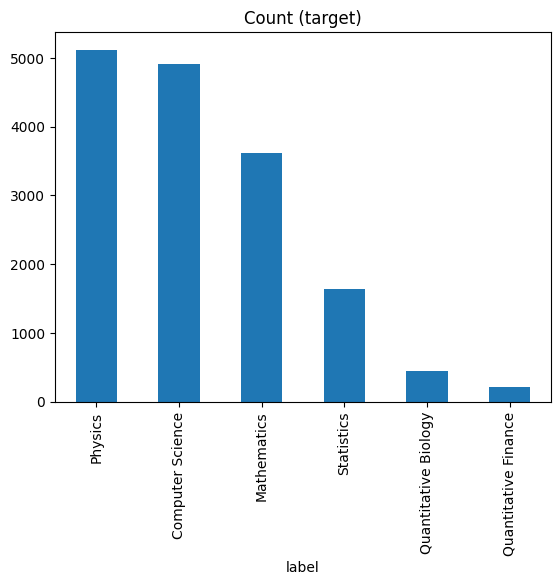

In [ ]:
df['label'].value_counts().plot(kind='bar', title='Count (target)')

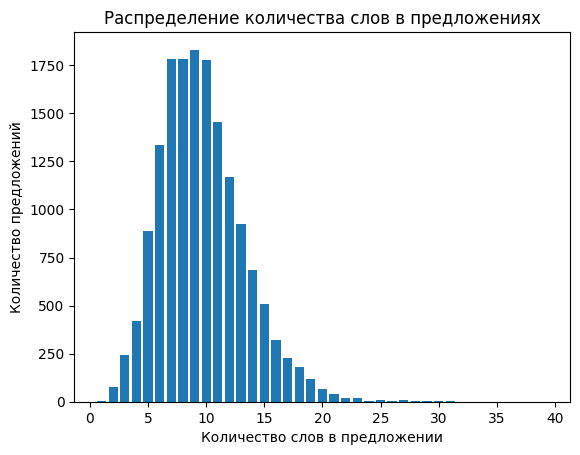

In [ ]:
len_df = pd.DataFrame(df).copy()

# Добавляем столбец с количеством слов в предложении
len_df['word_count'] = df['text'].apply(lambda x: len(x.split()))

# Строим гистограмму
plt.hist(len_df['word_count'], bins=range(min(len_df['word_count']), max(len_df['word_count']) + 1, 1), rwidth=0.8, align='left')
plt.xlabel('Количество слов в предложении')
plt.ylabel('Количество предложений')
plt.title('Распределение количества слов в предложениях')
plt.show()

In [ ]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
import torch
from torch import nn
from transformers import DistilBertTokenizer, DistilBertModel, AdamW
from torch.optim import Adam, SGD, RMSprop, Adagrad, Adadelta
from tqdm import tqdm

In [ ]:
labels = {}
for index, label in enumerate(df['label'].unique()):
    labels[label] = index
labels

{'Computer Science': 0,
 'Mathematics': 1,
 'Physics': 2,
 'Quantitative Biology': 3,
 'Statistics': 4,
 'Quantitative Finance': 5}

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, df, max_length):
        self.labels = [labels[label] for label in df['label']]
        self.texts = [tokenizer(text,
                               padding='max_length', max_length = max_length, truncation=True,
                                return_tensors="pt") for text in df['text']]
    def classes(self):
        return self.labels
    def __len__(self):
        return len(self.labels)
    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])
    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]
    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)
        return batch_texts, batch_y

In [ ]:
np.random.seed(112)
df_train, df_val = np.split(df.sample(frac=1, random_state=42),
                                     [int(.8*len(df))])

print(len(df_train),len(df_val))

12742 3186


In [ ]:
arch1_train_acc = []
arch1_valid_acc = []

In [ ]:
BATCH_SIZE=16
LEARNING_RATE=1e-6
EPOCHS=20
MAX_LEN = 64

In [ ]:
model_name = "distilbert-base-cased"
tokenizer = DistilBertTokenizer.from_pretrained(model_name, truncation=True, do_lower_case=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

In [ ]:
class BertClassifier(nn.Module):
    def __init__(self):
        super(BertClassifier, self).__init__()
        self.bert = DistilBertModel.from_pretrained(model_name)
        self.linear = nn.Linear(self.bert.config.hidden_size, self.bert.config.hidden_size)
        self.dropout = nn.Dropout(0.12)
        self.classifier = nn.Linear(self.bert.config.hidden_size, 6)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_id, mask):
        last_hidden_state = self.bert(input_ids=input_id, attention_mask=mask).last_hidden_state
        pooled_output = last_hidden_state[:, 0]
        # linear_output = nn.functional.relu(self.linear(pooled_output))
        dropped_output = self.dropout(pooled_output)
        logits = self.classifier(dropped_output)
        final_layer = self.softmax(logits)

        return final_layer

In [ ]:
model = BertClassifier()

model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

In [ ]:
def train(model, epochs):
    train, val = Dataset(df_train, MAX_LEN), Dataset(df_val, MAX_LEN)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=BATCH_SIZE)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss(label_smoothing=0.0)


    if use_cuda:
            print('on cuda')
            model = model.cuda()
            criterion = criterion.cuda()

    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

    for epoch_num in range(epochs):
            total_acc_train = 0
            total_loss_train = 0
            for train_input, train_label in tqdm(train_dataloader):
                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                model.zero_grad()

                output = model(input_id, mask)

                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()

                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc


                batch_loss.backward()
                optimizer.step()

            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()

                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc

            arch1_train_acc.append(total_acc_train / len(df_train))
            arch1_valid_acc.append(total_acc_val / len(df_val))

            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(df_train): .3f} \
                | Train Accuracy: {total_acc_train / len(df_train): .3f} \
                | Val Loss: {total_loss_val / len(df_val): .3f} \
                | Val Accuracy: {total_acc_val / len(df_val): .3f}')

In [ ]:
print('Adam, BS=16, lr=1e-6, ls=0.05')
print(LEARNING_RATE)
train(model, EPOCHS)

Adam, BS=16, lr=1e-6, ls=0.05
1e-06
on cuda


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
100%|██████████| 797/797 [01:11<00:00, 11.20it/s]


Epochs: 1 | Train Loss:  0.092                 | Train Accuracy:  0.619                 | Val Loss:  0.083                 | Val Accuracy:  0.736


100%|██████████| 797/797 [01:12<00:00, 10.94it/s]


Epochs: 2 | Train Loss:  0.082                 | Train Accuracy:  0.744                 | Val Loss:  0.082                 | Val Accuracy:  0.742


100%|██████████| 797/797 [01:12<00:00, 10.92it/s]


Epochs: 3 | Train Loss:  0.081                 | Train Accuracy:  0.757                 | Val Loss:  0.081                 | Val Accuracy:  0.747


 73%|███████▎  | 581/797 [00:53<00:19, 10.94it/s]


KeyboardInterrupt: 